tobac example: Tracking deep convection based on OLR from geostationary satellite retrievals
==

This example notebook demonstrates the use of tobac to track isolated deep convective clouds based on outgoing longwave radiation (OLR) calculated based on a combination of two different channels of the GOES-13 imaging instrument.

The data used in this example is downloaded from "zenodo link" automatically as part of the notebooks (This only has to be done once for all the tobac example notebooks).

In [1]:
# Import libraries:
import iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
import shutil
from six.moves import urllib
from pathlib import Path
%matplotlib inline

In [2]:
# Import tobac itself:
import tobac
print('using tobac version', str(tobac.__version__))

using tobac version 1.5.4


In [3]:
# Disable a few warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

**Download example data:**   
This has to be done only once for all tobac examples.

In [4]:
data_out=Path('../')

In [5]:
# Download the data: This only has to be done once for all tobac examples and can take a while
data_file = list(data_out.rglob('data/Example_input_OLR_satellite.nc'))
if len(data_file) == 0:
    file_path='https://zenodo.org/records/3195910/files/climate-processes/tobac_example_data-v1.0.1.zip'
    #file_path='http://zenodo..'
    tempfile=Path('temp.zip')
    print('start downloading data')
    request=urllib.request.urlretrieve(file_path, tempfile)
    print('start extracting data')
    shutil.unpack_archive(tempfile, data_out)
    tempfile.unlink()
    print('data extracted')
    data_file = list(data_out.rglob('data/Example_input_OLR_satellite.nc'))

**Load data:**

In [6]:
# Load Data from downloaded file:
OLR=iris.load_cube(str(data_file[0]),'OLR')

In [7]:
# Display information about the input data cube:
display(OLR)

<iris 'Cube' of OLR / (W m^-2) (time: 54; latitude: 131; longitude: 184)>

In [8]:
#Set up directory to save output and plots:
savedir=Path("Save")
if not savedir.is_dir():
    savedir.mkdir()
plot_dir=Path("Plot")
if not plot_dir.is_dir():
    plot_dir.mkdir()

**Feature identification:**  
Identify features based on OLR field and a set of threshold values

In [9]:
# Determine temporal and spatial sampling of the input data:
dxy,dt=tobac.get_spacings(OLR,grid_spacing=4000)

In [10]:
# Keyword arguments for the feature detection step
parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']=0.5
parameters_features['n_min_threshold']=4
parameters_features['target']='minimum'
parameters_features['threshold']=[250,225,200,175,150]

In [11]:
# Feature detection and save results to file:
print('starting feature detection')
Features=tobac.feature_detection_multithreshold(OLR,dxy,**parameters_features)
Features.to_hdf(savedir / 'Features.h5','table')
print('feature detection performed and saved')


starting feature detection
feature detection performed and saved


**Segmentation:**  
Segmentation is performed based on the OLR field and a threshold value to determine the cloud areas.

In [12]:
# Keyword arguments for the segmentation step:
parameters_segmentation={}
parameters_segmentation['target']='minimum'
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=250

In [13]:
# Perform segmentation and save results to files:
Mask_OLR,Features_OLR=tobac.segmentation_2D(Features,OLR,dxy,**parameters_segmentation)
print('segmentation OLR performed, start saving results to files')
iris.save([Mask_OLR], savedir / 'Mask_Segmentation_OLR.nc', zlib=True, complevel=4)                
Features_OLR.to_hdf(savedir / 'Features_OLR.h5', 'table')
print('segmentation OLR performed and saved')

segmentation OLR performed, start saving results to files
segmentation OLR performed and saved


**Trajectory linking:**  
The detected features are linked into cloud trajectories using the trackpy library (http://soft-matter.github.io/trackpy). This takes the feature positions determined in the feature detection step into account but does not include information on the shape of the identified objects.

In [14]:
# keyword arguments for linking step
parameters_linking={}
parameters_linking['v_max']=20
parameters_linking['stubs']=2
parameters_linking['order']=1
parameters_linking['extrapolate']=0
parameters_linking['memory']=0
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['subnetwork_size']=100
parameters_linking['method_linking']= 'predict'

In [15]:
# Perform linking and save results to file:
Track=tobac.linking_trackpy(Features,OLR,dt=dt,dxy=dxy,**parameters_linking)
Track.to_hdf(savedir / 'Track.h5','table')

Frame 53: 11 trajectories present.


**Visualisation:**  

In [16]:
# Set extent of maps created in the following cells:
axis_extent=[-95,-89,28,32]        

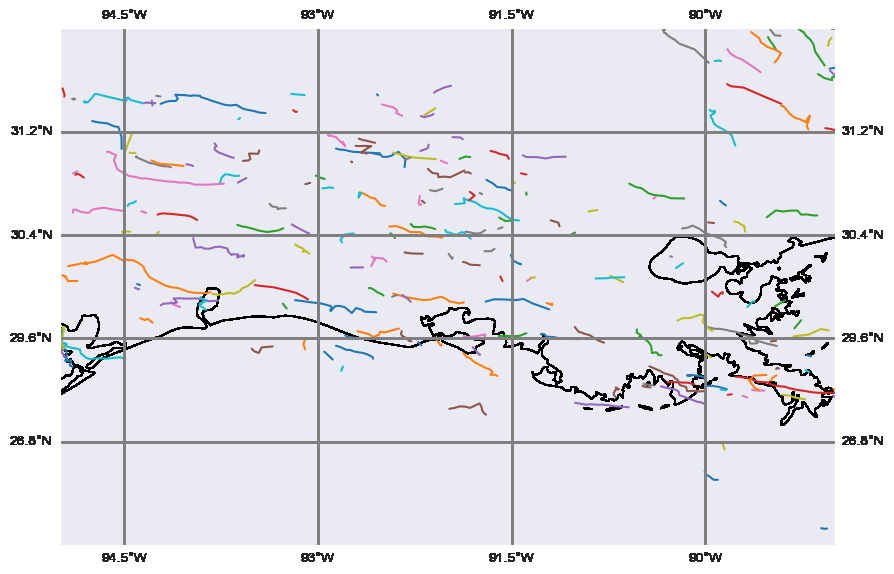

In [17]:
# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(10,10),subplot_kw={'projection': ccrs.PlateCarree()})
ax_map=tobac.map_tracks(Track,axis_extent=axis_extent,axes=ax_map)

In [18]:
# Create animation of tracked clouds and outlines with OLR as a background field
animation_test_tobac=tobac.animation_mask_field(Track,Features,OLR,Mask_OLR,
                                          axis_extent=axis_extent,#figsize=figsize,orientation_colorbar='horizontal',pad_colorbar=0.2,
                                          vmin=80,vmax=330,cmap='Blues_r',
                                          plot_outline=True,plot_marker=True,marker_track='x',plot_number=True,plot_features=True)

In [19]:
# Display animation:
from IPython.display import HTML, Image, display
HTML(animation_test_tobac.to_html5_video())

<Figure size 640x480 with 0 Axes>

In [20]:
# # Save animation to file:
# savefile_animation=plot_dir / 'Animation.mp4'
# animation_test_tobac.save(savefile_animation,dpi=200)
# print(f'animation saved to {savefile_animation}')

Text(0, 0.5, 'counts')

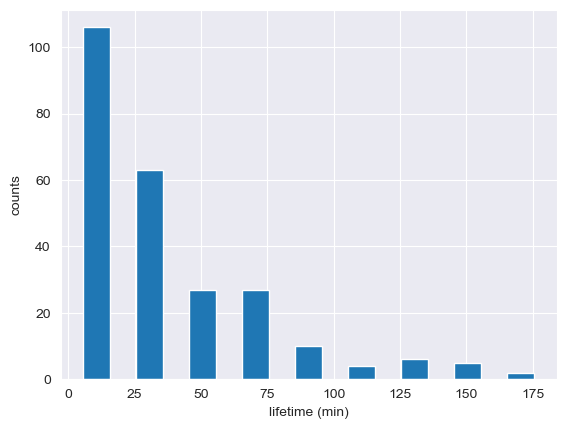

In [21]:
# Lifetimes of tracked clouds:
fig_lifetime,ax_lifetime=plt.subplots()
tobac.plot_lifetime_histogram_bar(Track,axes=ax_lifetime,bin_edges=np.arange(0,200,20),density=False,width_bar=10)
ax_lifetime.set_xlabel('lifetime (min)')
ax_lifetime.set_ylabel('counts')
         